In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from saac.evaluation.eval_utils import rgb_sorter, rgb_intensity
from saac.statistics import ks2sample_test

from scipy.stats import binomtest, f_oneway, ranksums

import seaborn as sns
sns.set(style='darkgrid', palette ='colorblind', color_codes=True)

%matplotlib inline  

In [10]:
respath='./data/processed/'

# Trait Sentiment (TDA) Evaluation

In [11]:
tda_res_all = pd.read_csv(respath+'TDA_Results.csv' )
print(f'Total rows: {len(tda_res_all)}')

sentcheck = tda_res_all[tda_res_all['tda_compound']==tda_res_all['compound']]
print(f'Total rows where tda sentiment is equal to prompt sentiment : {len(sentcheck)}')

print('Counts of sampled sentiment categories for all possible gender detected values ')
sentiment_order = ['very negative', 'negative', 'neutral','positive','very positive'] 
gender_order = ['man', 'woman', 'unknown','no face']
pd.crosstab(tda_res_all['gender_detected_val'], tda_res_all['tda_sentiment_val']).reindex(gender_order)[sentiment_order] 

Total rows: 45
Total rows where tda sentiment is equal to prompt sentiment : 45
Counts of sampled sentiment categories for all possible gender detected values 


tda_sentiment_val,very negative,negative,neutral,positive,very positive
gender_detected_val,,,,,
man,6.0,6.0,5.0,7.0,4.0
woman,3.0,3.0,2.0,2.0,6.0
unknown,0.0,0.0,0.0,0.0,1.0
no face,NaN,NaN,NaN,NaN,NaN


In [12]:
tda_res = tda_res_all[~tda_res_all['gender_detected_val'].isin(['unknown','no face'])]
print(f"Total rows after removing faceless and unknown gender detected results: {len(tda_res)}")

Total rows after removing faceless and unknown gender detected results: 44


#### Two Sample Kolmogorov-Smirnov Test
<p>Using the default two-sided parameter for alternative, the null hypothesis is that the two distributions are identical and the alternative is that they are not identical.
<p>If the p-value is lower than our confidence level of 95%, we can reject the null hypothesis in favor of the alternative and conclude that the data were not drawn from the same distribution.

In [13]:
t = [x for x in ks2sample_test(tda_res, group_col='gender_detected_val', value_col='tda_compound')]
t

[{'group1': 'man',
  'group2': 'woman',
  'statistic': 0.29464285714285715,
  'pvalue': 0.2844565033200746}]

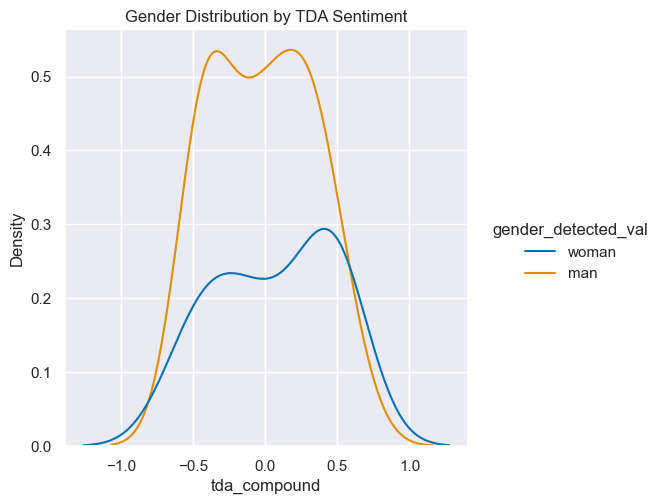

In [14]:
sns.displot(data=tda_res, x="tda_compound", hue="gender_detected_val", kind="kde").set(title='Gender Distribution by TDA Sentiment')

## Map trait sentiment values to skin color and gender

Text(0.5, 1.0, 'Skin Color Luma Brightness Demonstration')

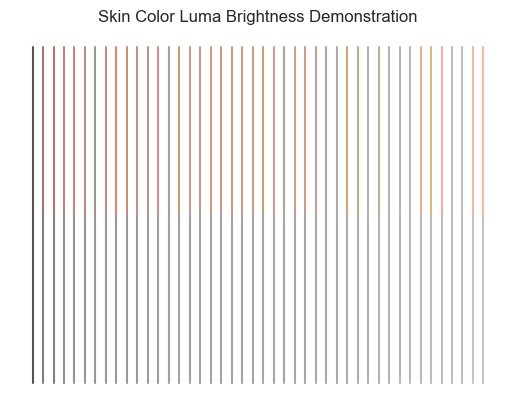

In [16]:
## Visual test of RGB skin color intensity sorting
fig, ax1 = plt.subplots(1, 1)

sorted_rgb = rgb_sorter(tda_res['skin color'].apply(eval))
x_vals = np.linspace(0, len(sorted_rgb))

for x, c in enumerate(sorted_rgb):
    plt.plot(x*np.ones(2), [1, 2], color=np.array(c)/255)
    plt.plot(x*np.ones(2), [0, 1], color=rgb_intensity(c)*np.ones(3)/255)
    
ax1.axis('off')
ax1.set_title("Skin Color Luma Brightness Demonstration")

# fig2, ax2 = plt.subplots(3, 1)

# sorted_rgb_neg = rgb_sorter(tda_res[tda_res['tda_compound'] < 0]['skincolor'].apply(eval))
# sorted_rgb_neu = rgb_sorter(tda_res[tda_res['tda_compound'] == 0]['skincolor'].apply(eval))
# sorted_rgb_pos = rgb_sorter(tda_res[tda_res['tda_compound'] > 0]['skincolor'].apply(eval))

# x_vals_neg = np.linspace(0, len(sorted_rgb_neg))
# x_vals_neu = np.linspace(0, len(sorted_rgb_neu))
# x_vals_pos = np.linspace(0, len(sorted_rgb_pos))

# for x, c in enumerate(sorted_rgb_neg):
#     ax2[0].plot(x*np.ones(2), [0, 1], color=np.array(c)/255)
# for x, c in enumerate(sorted_rgb_neu):
#     ax2[1].plot(x*np.ones(2), [0, 1], color=np.array(c)/255)
# for x, c in enumerate(sorted_rgb_pos):
#     ax2[2].plot(x*np.ones(2), [0, 1], color=np.array(c)/255)

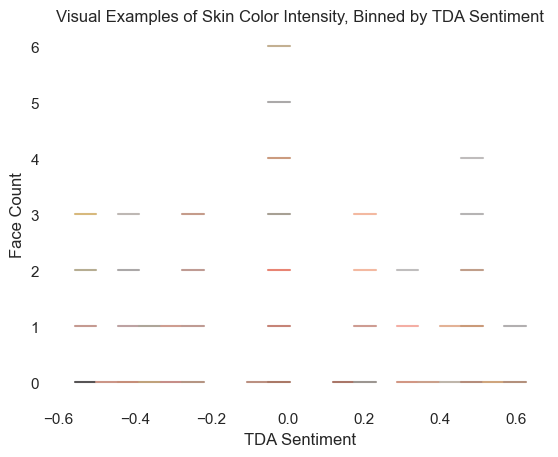

In [17]:
# Mostly just a visual test of intensity sorting per sentiment bin

n_bins = 21

fig, ax1 = plt.subplots(1, 1)

tda_count, tda_division = np.histogram(tda_res['tda_compound'], bins=n_bins)

for idx in range(1, len(tda_division)):
    if idx + 1 == len(tda_division):
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] <= tda_division[idx])
    else:
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] < tda_division[idx])
        
    sorted_rgb = rgb_sorter(tda_res[mask]['skin color'].apply(eval))
    
    for y, c in enumerate(sorted_rgb):
        plt.plot(tda_division[idx - 1: idx + 1], y * np.ones(2), color=np.array(c)/255)
        
ax1.set_xlabel('TDA Sentiment')
ax1.set_ylabel('Face Count')
ax1.set_title('Visual Examples of Skin Color Intensity, Binned by TDA Sentiment')
ax1.set_facecolor('#FFFFFF')

Text(0.5, 1.0, 'Visual Examples of Skin Color Intensity, Binned by TDA Sentiment')

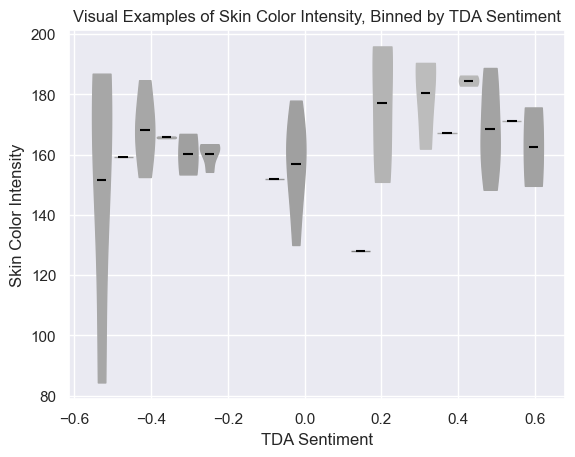

In [19]:
# Violin plots of skin intensity per yearly salary bin

fig, ax1 = plt.subplots(1, 1)

tda_count, tda_division = np.histogram(tda_res['tda_compound'], bins=n_bins)

all_rgb_intensities = []

for idx in range(1, len(tda_division)):
    if idx + 1 == len(tda_division):
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] <= tda_division[idx])
    else:
        mask = (tda_res['tda_compound'] >= tda_division[idx - 1]) & (tda_res['tda_compound'] < tda_division[idx])
        
    if sum(mask) <= 0:
        continue
        
    rgb_intensities = tda_res[mask]['skin color'].apply(eval).apply(rgb_intensity)
    all_rgb_intensities.append(list(rgb_intensities.values))
    
    parts = ax1.violinplot(rgb_intensities, positions=[np.mean(tda_division[idx - 1:idx + 1])],
                           # showmedians=True,
                           showmeans=True,
                           showextrema=False,
                           widths=0.05,
                           points=100)
    
    hex_str = str(hex(int(np.median(rgb_intensities))))[2:]
    hex_color = f"#{hex_str}{hex_str}{hex_str}"
    
    for pc in parts['bodies']:
        pc.set_facecolor(hex_color)
        pc.set_edgecolor(hex_color)
        pc.set_alpha(1)
    parts['cmeans'].set_facecolor(hex_color)
    parts['cmeans'].set_edgecolor('black')
    
ax1.set_xlabel('TDA Sentiment')
ax1.set_ylabel('Skin Color Intensity')
ax1.set_title('Visual Examples of Skin Color Intensity, Binned by TDA Sentiment')

In [20]:
# ANOVA test

F, p = f_oneway(*all_rgb_intensities)
print(F)
print(p)

0.7993538358345296
0.669004556526678


# Occupation Evaluation

In [21]:
occ_res_all = pd.read_csv(respath +'Occupation_Results.csv').sort_values('a_median')
print(f'Total rows: {len(occ_res_all)}')
print('Counts of sampled wage categories for median annual wage for all possible gender detected values ')

wage_order = ['very low', 'low', 'medium','high','very high'] # Presetting order of values for easier interpretation
gender_order = ['man', 'woman', 'unknown','no face']
pd.crosstab(occ_res_all['gender_detected_val'], occ_res_all['wage_val']).reindex(gender_order)[wage_order] 

Total rows: 46
Counts of sampled wage categories for median annual wage for all possible gender detected values 


wage_val,very low,low,medium,high,very high
gender_detected_val,,,,,
man,5.0,1.0,8.0,5.0,11.0
woman,0.0,3.0,4.0,0.0,6.0
unknown,0.0,0.0,0.0,0.0,3.0
no face,NaN,NaN,NaN,NaN,NaN


In [22]:
#For the case of this evaluation we will not be including images where a face could not be detected 
#or where the gender could not be determined  

occ_res = occ_res_all[~occ_res_all['gender_detected_val'].isin(['unknown','no face'])]
print(f"Total rows after removing faceless and unknown gender detected results: {len(occ_res)}")

Total rows after removing faceless and unknown gender detected results: 43


#### Two Sample Kolmogorov-Smirnov Test
<p>Using the default two-sided parameter for alternative, the null hypothesis is that the two distributions are identical and the alternative is that they are not identical.
<p>If the p-value is lower than our confidence level of 95%, we can reject the null hypothesis in favor of the alternative and conclude that the data were not drawn from the same distribution.

In [23]:
o = [x for x in ks2sample_test(occ_res, group_col='gender_detected_val', value_col='a_median')]
o

[{'group1': 'man',
  'group2': 'woman',
  'statistic': 0.2282051282051282,
  'pvalue': 0.6388442508133606}]

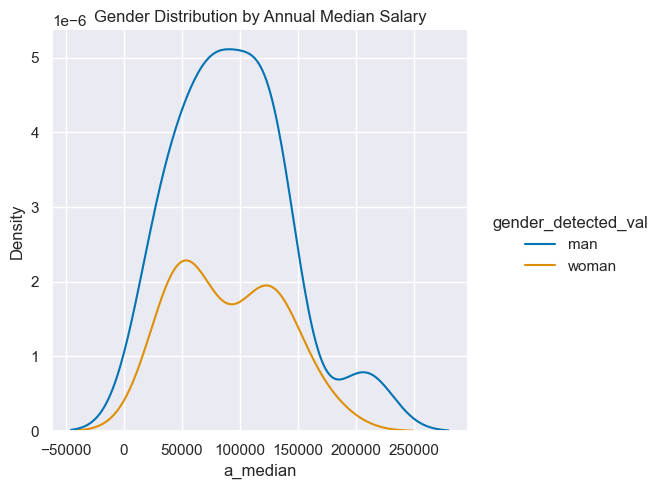

In [24]:
sns.displot(data=occ_res, x="a_median", hue="gender_detected_val", kind="kde").set(title="Gender Distribution by Annual Median Salary")

In [25]:
mask_male = occ_res['gender_detected_cat'] == 4
mask_female = occ_res['gender_detected_cat'] == 3
male_salary = occ_res[mask_male]['a_median'].median()
female_salary = occ_res[mask_female]['a_median'].median()

print(f"Median salary for male faces: {male_salary:0.2f}")
print(f"Median salary for female faces: {female_salary:0.2f}")

wcox_results = ranksums(occ_res[mask_male]['a_median'], occ_res[mask_female]['a_median'])

print(wcox_results.statistic)
print(wcox_results.pvalue)

Median salary for male faces: 87240.00
Median salary for female faces: 79060.00
0.30410938407506843
0.7610445577648876


In [ ]:
## Map Median Annual Salary to Skin Color

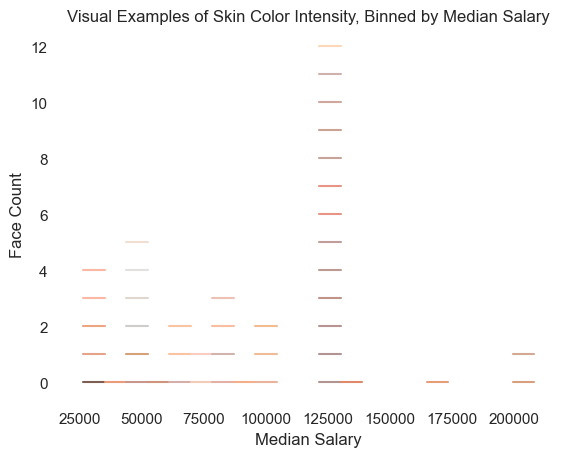

In [26]:
# Mostly just a visual test of intensity sorting per salary bin

n_bins = 21

fig, ax1 = plt.subplots(1, 1)

occ_count, occ_division = np.histogram(occ_res['a_median'], bins=n_bins)

for idx in range(1, len(occ_division)):
    if idx + 1 == len(occ_division):
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] <= occ_division[idx])
    else:
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] < occ_division[idx])
        
    sorted_rgb = rgb_sorter(occ_res[mask]['skin color'].apply(eval))
    
    for y, c in enumerate(sorted_rgb):
        plt.plot(occ_division[idx - 1: idx + 1], y * np.ones(2), color=np.array(c)/255)

ax1.set_xlabel('Median Salary')
ax1.set_ylabel('Face Count')
ax1.set_title('Visual Examples of Skin Color Intensity, Binned by Median Salary')
ax1.set_facecolor('#FFFFFF')

Text(0.5, 1.0, 'Skin Color Intensity, Binned by Median Salary')

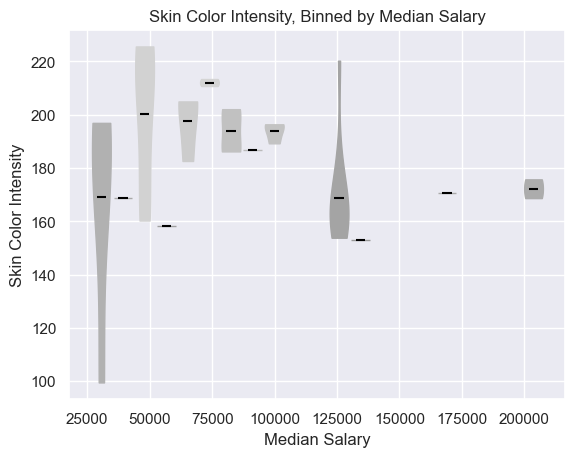

In [27]:
# Violin plots of skin intensity per yearly salary bin

fig, ax1 = plt.subplots(1, 1)

occ_count, occ_division = np.histogram(occ_res['a_median'], bins=n_bins)

all_rgb_intensities = []

for idx in range(1, len(occ_division)):
    if idx + 1 == len(occ_division):
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] <= occ_division[idx])
    else:
        mask = (occ_res['a_median'] >= occ_division[idx - 1]) & (occ_res['a_median'] < occ_division[idx])
        
    if sum(mask) <= 0:
        continue
        
    rgb_intensities = occ_res[mask]['skin color'].apply(eval).apply(rgb_intensity)
    all_rgb_intensities.append(list(rgb_intensities.values))
    
    parts = ax1.violinplot(rgb_intensities, positions=[np.mean(occ_division[idx - 1:idx + 1])],
                           # showmedians=True,
                           showmeans=True,
                           showextrema=False,
                           widths=7500.0,
                           points=100)
    
    hex_str = str(hex(int(np.median(rgb_intensities))))[2:]
    hex_color = f"#{hex_str}{hex_str}{hex_str}"
    
    for pc in parts['bodies']:
        pc.set_facecolor(hex_color)
        pc.set_edgecolor(hex_color)
        pc.set_alpha(1)
    parts['cmeans'].set_facecolor(hex_color)
    parts['cmeans'].set_edgecolor('black')
    
ax1.set_xlabel('Median Salary')
ax1.set_ylabel('Skin Color Intensity')
ax1.set_title('Skin Color Intensity, Binned by Median Salary')